# Задание

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

# Импорт необходимых библиотек и модулей
В данном блоке подключаются все необходимые для задачи библиотеки и модули.

- Импортируются стандартные библиотеки для работы с файлами (os, Path), массивами (numpy) и визуализацией (matplotlib.pyplot).

- Подключается gdown для загрузки данных из Google Drive или подобных источников.

- Из TensorFlow Keras импортируются слои для построения нейронных сетей: свёрточные, полносвязные, нормализации, активации, дропаут и другие.

- Импортируются оптимизаторы Adam и SGD для настройки процесса обучения.

- Импортируется предварительно обученная модель VGG19 из tf.keras.applications для возможного использования transfer learning.

- Подключается класс ImageDataGenerator для создания потоков аугментированных изображений, что помогает увеличить объем обучающих данных.

- Добавлено подавление предупреждений, чтобы блок не загромождался лишними уведомлениями во время работы.

In [ ]:
# Стандартная библиотека
import os
import warnings
import zipfile  # работа с zip-архивами
from pathlib import Path

warnings.filterwarnings("ignore")

# Сторонние библиотеки
import gdown
import matplotlib.pyplot as plt
import numpy as np

# TensorFlow / Keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    LeakyReLU,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка и распаковка датасета
Код проверяет, есть ли в текущей директории файл с именем middle_fmr.zip.

- Если файл уже присутствует, загрузка не выполняется (пропускается).

- Если файла нет, с помощью gdown скачивается zip-архив по заданной ссылке и сохраняется в текущую папку.

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
if "middle_fmr.zip" in os.listdir():
    pass
else:
    # Загрузка zip-архива с датасетом из облака на диск
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip",
        None,
        quiet=True,
    )

'middle_fmr.zip'

**Проверка, создание папки и распаковка архива**

Код проверяет, существует ли папка с именем cars в текущей директории.

- Если папка уже есть, ничего не происходит (pass).

- Если папки нет, она создаётся с помощью os.mkdir("cars").

Далее открывается архив middle_fmr.zip в режиме чтения, и его содержимое распаковывается в папку cars/cars_train. Таким образом, данные из архива будут организованы в отдельной вложенной папке внутри cars.

In [ ]:
if "cars" in os.listdir():  # Проверка наличия папки
    pass
else:
    # Создание папки cars для хранения датасета
    os.mkdir("cars")
    # Распаковка zip-архива
    with zipfile.ZipFile("middle_fmr.zip", "r") as zip_ref:
        zip_ref.extractall("cars/cars_train")

# Разделение датасета на обучающую, проверочную и тестовую выборки
В этом блоке реализуется подготовка структуры данных для обучения модели путем распределения изображений по трем наборам: обучающему, проверочному (валидационному) и тестовому.

1. Настройка параметров разделения:

Определяются доли выборок для тестовой и проверочной части — по 10% от исходного набора, остальное будет использовано для обучения.

2. Определение путей:

Устанавливаются пути к папкам с обучающими, проверочными и тестовыми данными. Если папки для валидации и теста ещё не созданы, они создаются автоматически.

3. Распределение данных по классам:

Для каждого класса из исходной обучающей папки создаются соответствующие папки в тестовой и проверочной выборках.

4. Перемещение файлов:

Файлы изображений внутри каждого класса делятся согласно заданным пропорциям. Первые 10% файлов перемещаются в тестовую выборку, следующие 10% — в проверочную, остальные остаются в обучающей папке. Это делается с помощью функции rename, которая перемещает файлы по файловой системе.

In [ ]:
# Размер деления выборки на тестовую, проверочную и обучающую
TEST_SPLIT = VAL_SPLIT = 0.1
TRAIN_PATH = Path("cars/cars_train")
VAL_PATH = Path("cars/cars_val")
TEST_PATH = Path("cars/cars_test")

if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)
    VAL_PATH.mkdir(exist_ok=True)

    for classfolder in TRAIN_PATH.iterdir():
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())
        len_class = len(files)
        test_len = int(len_class * TEST_SPLIT)
        val_len = int(len_class * VAL_SPLIT)

        for i, img in enumerate(files):
            if i < test_len:
                img.rename(classfolder_test / img.name)
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break


# Аугментация и нормализация данных
В этом блоке происходит подготовка данных с помощью аугментации для улучшения качества и устойчивости модели:

1. Аугментация обучающих данных: для обучающего набора создаётся генератор train_datagen, который случайным образом изменяет изображения, применяя:

- Повороты до 15 градусов (rotation_range)

- Сдвиги по ширине и высоте на 10% и 5% соответственно (width_shift_range, height_shift_range)

- Масштабирование с изменением размера до 20% (zoom_range)

- Изменение яркости в диапазоне от 70% до 130% (brightness_range)

- Горизонтальное отражение (horizontal_flip)

- Нормализацию пикселей в диапазон [0, 1] (rescale=1.0/255.0)

2. Нормализация для тестовых и валидационных данных: для тестового и проверочного наборов создаётся генератор test_and_val_datagen, который лишь нормализует пиксели, приводя значения к диапазону [0, 1] без аугментации.

In [ ]:
# Аугументация и нормализация данных
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.05,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    rescale=1.0 / 255.0,
)

test_and_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)


В этом блоке задаются ключевые параметры для обработки изображений и обучения модели:

- IMG_HEIGHT = 108 — высота входных изображений в пикселях. Все изображения будут приведены к этому размеру по вертикали.

- IMG_WIDTH = 192 — ширина входных изображений в пикселях. Все изображения будут приведены к этому размеру по горизонтали.

- BATCH_SIZE = 64 — количество изображений, обрабатываемых одновременно за один шаг обучения (батч). Это значение влияет на скорость обучения и использование памяти.

In [ ]:
# Параметры изображения
IMG_HEIGHT = 108
IMG_WIDTH = 192
BATCH_SIZE = 64

# Создание генераторов данных для обучения, проверки и тестирования
В этом блоке на основе заранее подготовленных папок с изображениями создаются генераторы, которые будут подавать данные в модель по частям (батчами):

- train_generator: создаётся из папки обучающего набора. Использует аугментацию (преобразования изображений) и нормализацию, заданные в train_datagen. Изображения приводятся к размерам 108×192, перемешиваются (shuffle=True), и метки кодируются как категории (one-hot).

- validation_generator: создаётся из папки проверочного набора. Применяется только нормализация, без аугментации (используется test_and_val_datagen). Размеры изображений совпадают с тренировочным генератором, данные также перемешиваются.

- test_generator: аналогично валидационному, только данные не перемешиваются (shuffle=False), что важно для корректной оценки модели.

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Проверочная выборка генерируется из папки проверочного набора
validation_generator = test_and_val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_and_val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 2745 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


Следующий код выводит распределение количества изображений по классам в каждой из выборок: обучающей, проверочной и тестовой.

Функция np.bincount() подсчитывает, сколько раз встречается каждый класс (числовой индекс) в списке классов, который хранится в атрибуте .classes у каждого генератора.

In [ ]:
print("Распределение изображений для классов, обучающей выборки:", np.bincount(train_generator.classes))
print("Распределение изображений для классов, проверочной выборки:", np.bincount(validation_generator.classes))
print("Распределение изображений для классов, тестовой выборки:", np.bincount(test_generator.classes))


Распределение изображений для классов, обучающей выборки: [872 929 944]
Распределение изображений для классов, проверочной выборки: [108 116 117]
Распределение изображений для классов, тестовой выборки: [108 116 117]


# Визуализация примеров из обучающей выборки с аугментацией
Этот блок кода выполняет визуализацию примеров из обучающего набора данных, сгенерированных генератором train_generator.

Сначала с помощью next(train_generator) получается один батч изображений и соответствующих меток (labels).

Далее отображаются первые два изображения из этого батча с помощью matplotlib, каждое изображение показывается вместе с его меткой.

Метках — это one-hot векторы, поэтому заголовок с меткой будет представлен в виде массива, что удобно для проверки корректности аугментации и формата данных перед обучением модели.

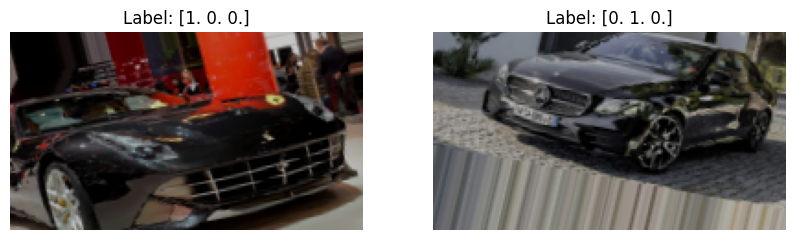

In [ ]:
# Получаем один батч изображений и меток из генератора
images, labels = next(train_generator)

# Выводим первые несколько изображений из батча
num_images_to_show = 2
plt.figure(figsize=(10, 5))

for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

# Создание и компиляция модели на основе предобученной архитектуры VGG19
В этом блоке загружается предобученная модель VGG19 без верхних (классификационных) слоев с весами ImageNet и фиксируются (замораживаются) все слои, кроме последних пяти, которые размораживаются для тонкой дообучаемости.

Далее создаётся последовательная модель Keras, включающая базовую VGG19, слой глобального усредняющего пуллинга, два слоя Dropout для регуляризации, полносвязный слой с активацией ReLU и выходной слой с softmax для задачи многоклассовой классификации (3 класса).

Модель компилируется с оптимизатором SGD с моментумом и функцией потерь categorical_crossentropy для эффективного обучения классификатора.

In [ ]:
# Загружаем модель VGG19 без верхних слоев (головы), с предобученными весами ImageNet
base_model = VGG19(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Замораживаем все слои базовой модели (чтобы не обучались)
for layer in base_model.layers:
    layer.trainable = False

# Размораживаем последние 5 слоев для дообучения
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Создаем модель на основе VGG19 с добавлением своих слоев классификации
model_vgg = Sequential(
    [
        base_model,                     # Базовая модель VGG19
        GlobalAveragePooling2D(),       # Глобальный усредняющий пуллинг
        Dropout(0.6),                   # Dropout
        Dense(512, activation="relu"),  # Полносвязный слой с ReLU
        Dropout(0.6),                   # Dropout
        Dense(3, activation="softmax")  # Выходной слой для 3 классов
    ]
)

# Компиляция модели с оптимизатором SGD и функцией потерь для многоклассовой классификации.
model_vgg.compile(
    # optimizer=Adam(learning_rate=0.00001),  # альтернативный оптимизатор (закомментирован)
    optimizer=SGD(learning_rate=0.003, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Вывод структуры модели
В этом блоке с помощью метода summary() выводится архитектура построенной модели на основе VGG19 с детальной информацией о слоях, количестве параметров в каждом слое, а также общем числе обучаемых и не обучаемых параметров.

In [ ]:
# Выведем структуру и параметры
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 6, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,288,579 (77.39 MB)

 Trainable params: 9,703,427 (37.02 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

# Обучение модели на основе VGG19
В этом блоке происходит обучение созданной модели с использованием генераторов данных:

- Используется метод .fit() для запуска процесса обучения.

- Данные подаются с помощью генератора train_generator, который динамически подает аугментированные изображения батчами.

- Валидация проводится на данных из validation_generator.

- Количество эпох обучения — 150, что позволяет модели хорошо адаптироваться к данным.

- Параметр verbose=1 обеспечивает вывод прогресса обучения в консоль.

In [ ]:
# Обучим полученную модель
history_vgg = model_vgg.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 623ms/step - accuracy: 0.3449 - loss: 1.2925 - val_accuracy: 0.5484 - val_loss: 1.0763
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.4160 - loss: 1.0622 - val_accuracy: 0.5660 - val_loss: 0.8664
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.5551 - loss: 0.9139 - val_accuracy: 0.6158 - val_loss: 0.8235
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 511ms/step - accuracy: 0.6155 - loss: 0.8228 - val_accuracy: 0.7771 - val_loss: 0.5708
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - accuracy: 0.7251 - loss: 0.6853 - val_accuracy: 0.8152 - val_loss: 0.4455
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - accuracy: 0.7769 - loss: 0.5714 - val_accuracy: 0.8152 - val_loss: 0.5319
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 517ms/step - accuracy: 0.7452 - loss: 0.6268 - val_accuracy: 0.7947 - val_loss: 0.4582
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 502ms/step - accuracy: 0.8071 - loss: 0.5227 - 

# Визуализация процесса обучения модели
В этом блоке строятся графики для анализа динамики обучения модели на основе истории тренировки:

- Левая диаграмма отображает изменение точности модели (accuracy) на обучающем и проверочном наборах по эпохам.

- Правая диаграмма показывает изменение значения функции потерь (loss) на обучающем и проверочном наборах.

- Оси X настроены на отображение целых чисел, соответствующих номерам эпох.

- Легенды помогают отличать кривые для обучающей и проверочной выборок.

Графики позволяют визуально оценить, происходит ли переобучение или недообучение, и насколько стабильно растет точность.

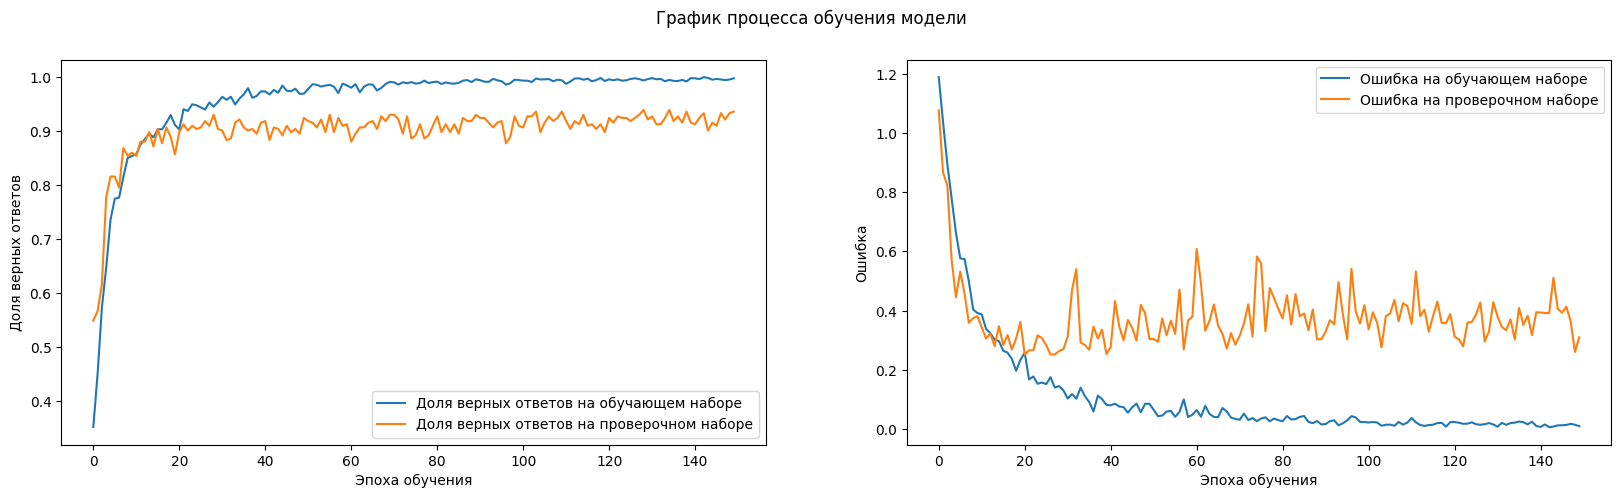

In [ ]:
# Визуализируем ход обучения модели

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history_vgg.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history_vgg.history["val_accuracy"], label="Доля верных ответов на проверочном наборе"
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_vgg.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_vgg.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()


# Оценка качества модели на тестовой выборке
В этом блоке производится оценка обученной модели на отложенной тестовой выборке:

- Метод evaluate запускает предсказания модели на данных тестового генератора test_generator.

- Возвращается значение функции потерь и метрики точности.

- Точность тестовой выборки (test_acc) показывает, насколько хорошо модель обобщается на новых данных, не участвовавших в обучении.

- Этот показатель является ключевым для проверки качества и практической применимости модели.

In [ ]:
_, test_acc = model_vgg.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9141 - loss: 0.4854


# Вывод итоговой точности модели
В этом блоке выводятся основные показатели точности модели:

- Точность на обучающей выборке (accuracy) — насколько хорошо модель обучилась на тренировочных данных.

- Точность на проверочной выборке (val_accuracy) — качество модели на валидационных данных, используемых для контроля переобучения.

- Точность на тестовой выборке (test_acc) — итоговая оценка модели на новых, ранее не виденных данных.

In [ ]:
print(
    f"Точность на обучающей выборке: {history_vgg.history['accuracy'][-1] * 100:.2f},\n"
    f"точность на проверочной выборке: {history_vgg.history['val_accuracy'][-1] * 100:.2f},\n"
    f"точность на тестовой выборке: {test_acc * 100:.2f}."
)

Точность на обучающей выборке: 99.71,
точность на проверочной выборке: 93.55,
точность на тестовой выборке: 91.50.


# Вывод по заданию
Модель достигла высокой точности на обучающей выборке — 99.71%, что свидетельствует о том, что она хорошо запомнила тренировочные данные. При этом точность на проверочной выборке составила 93.55%, а на тестовой — 91.50%.

Это говорит о том, что модель демонстрирует хорошую обобщающую способность и не сильно переобучилась, успешно распознавая пассажиров на новых данных. Достигнутый уровень точности выше требуемых 90%, что свидетельствует об успешном решении задачи классификации с использованием предобученной архитектуры VGG19 и аугментации данных.